In [1]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from pandas_datareader import data as pdr
import requests
from datetime import datetime
from bs4 import BeautifulSoup

# Задание 1.

Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Волшебный белый порошок" (ВБП), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на ВБП. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Дополнительные вводные:

Так как продукт Б новый, возможно стоит предложить дисконт от цены Продукта А. Продукт производиться из нефти. Один из известных способов производства предполагает что из 16 баррелей нефти сделают одну тонну ВБП, а затраты на производство в районе 400 евро.

In [2]:
# Из данных есть:
# Цены на продукт А, который уже есть на рынке Европы
# ----- октябрь 2018 - 
# ----- ноябрь 2018 - 
# ----- февраль 2019 -

# Котировки нефти, курс eur/usd
dbc = pd.read_excel('cur_oil.xlsx')

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    },
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками. 
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.

In [3]:
# базовая формула: price_per_tone = 16*(цена нефти, usd) + (затраты на производство, usd)
def pricing(oil_price, eur_usd):
    price = round(oil_price*16 + 400/eur_usd, 2)
    return price

In [4]:
price_hist = pd.DataFrame({'Date': dbc['Date'], 'EURUSD=X': dbc['EURUSD=X'], 'Product_price': pricing(dbc.OIL, dbc['EURUSD=X'])})

3. Отобразить на графике.

<AxesSubplot:>

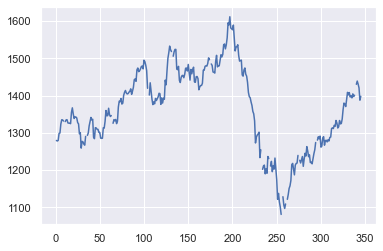

In [5]:
price_hist['Product_price'].plot(x='Date')

4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.

In [6]:
writer = pd.ExcelWriter('prices_for_clients.xlsx', engine='xlsxwriter')
for customer in customers:
    volume = customers[customer]['volumes']
    if volume < 100:
        disc = discounts['up to 100']
    elif 100 <= volume < 300:
        disc = discounts['up to 300']
    else:
        disc = discounts['300 plus']
    if customers[customer]['location'] == 'EU':
        temp_df =  pd.DataFrame({'Date': price_hist['Date'],\
                    'B_price': (price_hist['Product_price'] + EU_LOGISTIC_COST_EUR / price_hist['EURUSD=X'])*(1-disc)})
        temp_df.to_excel(writer, sheet_name=f'{customer}', index=False)
        
    elif customers[customer]['location'] == 'CN':
        temp_df =  pd.DataFrame({'Date': dbc['Date'],\
                    'B_price': price_hist['Product_price'] + CN_LOGISTIC_COST_USD})
        temp_df.to_excel(writer, sheet_name=f'{customer}', index=False)
writer.save()
writer.close()

C:\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
   - Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
   - Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf) с именем клиента…

In [7]:
os.mkdir('для_клиентов')

In [8]:
for customer in customers:
    file_path = os.path.join('для_клиентов', f'{customer}.xlsx')
    if customers[customer]['location'] == 'EU':
        temp_df =  pd.DataFrame({'Date': price_hist['Date'],\
                    'B_price': price_hist['Product_price'] + EU_LOGISTIC_COST_EUR / price_hist['EURUSD=X']})
        temp_df.to_excel(file_path, index=False)
        
    elif customers[customer]['location'] == 'CN':
        temp_df =  pd.DataFrame({'Date': dbc['Date'],\
                    'B_price': price_hist['Product_price'] + CN_LOGISTIC_COST_USD})
        temp_df.to_excel(file_path, index=False)

# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [9]:
class Pricer():
    def __init__(self, customers, discounts, eu_log_cost, cn_log_cost, prod_cost):
        self.customers = customers
        self.discounts = discounts
        self.eu_log_cost = eu_log_cost
        self.cn_log_cost = cn_log_cost
        self.prod_cost = prod_cost
        self.urls = {'oil': 'https://quote.rbc.ru/ticker/181206',
                     'eur/usd': 'https://quote.rbc.ru/ticker/59087'}
        
    # Статический метод для избежания дублирования кода в методах get_oil_price и get_eur_usd
    @staticmethod
    def parser(url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        return soup
    
    # метод получает стоимость нефти
    def get_oil_price(self):
        oil_price = self.parser(self.urls['oil']).find('span', class_='chart__info__sum').text
        oil_price = oil_price[1:]
        oil_price = float('.'.join(oil_price.split(',')))
        return oil_price
    
    # метод получает курс eur/usd
    def get_eur_usd(self):
        eur_usd = self.parser(self.urls['eur/usd']).find('span', class_='chart__info__sum').text
        eur_usd = eur_usd[1:]
        eur_usd = float('.'.join(eur_usd.split(',')))
        return eur_usd
    
    # метод добавляет скидку в словарь покупателей
    def get_discount(self):
        for customer in self.customers:
            try:
                if self.customers[customer]['volumes'] < 100:
                    self.customers[customer]['dicount'] = 1 - self.discounts['up to 100']
                elif self.customers[customer]['volumes'] < 300:
                    self.customers[customer]['dicount'] = 1 - self.discounts['up to 300']
                else:
                    self.customers[customer]['dicount'] = 1 - self.discounts['300 plus']
            except:
                self.customers[customer]['dicount'] = 1
    
    # метод расчитывает цены для всех покупателей
    def pricing(self):
        prices = dict()
        try:
            eur_usd = self.get_eur_usd()
        except:
            err = 'Курс eur/usd недоступен'
            return err
        try:
            oil_price = self.get_oil_price()
        except:
            err = 'Цена нефти недоступна'
            return err
        self.get_discount()
        for customer in self.customers:
            try:
                location = self.customers[customer]['location']
            except KeyError:
                location = None
            if location == 'EU':
                price = (16 * oil_price + self.eu_log_cost * eur_usd + self.prod_cost * eur_usd) * self.customers[customer]['dicount']
                price = round(price * eur_usd, 2)
                prices[customer] = f'{price} EUR'
            elif location == 'CN':
                price = (16 * oil_price + self.cn_log_cost + self.prod_cost) * self.customers[customer]['dicount']
                price = round(price, 2)
                prices[customer] = f'{price} USD'
            else:
                prices[customer] = f'Нет данных о расположении Клиента' 
        return prices

In [10]:
test = Pricer(customers, discounts, EU_LOGISTIC_COST_EUR, CN_LOGISTIC_COST_USD, PRODUCTION_COST)
test.pricing()

{'Monty': '2023.61 EUR',
 'Triangle': '1850.82 USD',
 'Stone': '2023.61 EUR',
 'Poly': '2108.81 EUR'}

# Задание 3. Back to Russia

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать ВБП для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a>.


In [11]:
# получаем дату для запроса к ЦБ
date = datetime.now()

if date.day < 10:
    d = '0' + str(date.day)
else:
    d = str(date.day)

if date.month < 10:
    m = '0' + str(date.month)
else:
    m = str(date.month)

y = str(date.year)

# запрос к ЦБ
url = 'https://cbr.ru/scripts/XML_daily.asp?'
params = {'date_req': f'{d}/{m}/{y}'}

response = requests.get(url, params)
soup = BeautifulSoup(response.content,'xml')
usd_rub = soup.find(ID='R01235').Value.string

usd_rub = float('.'.join(usd_rub.split(',')))

# подтягиваем стоимость нефти
url = 'https://quote.rbc.ru/ticker/181206'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
oil_price = soup.find('span', class_='chart__info__sum').text
oil_price = oil_price[1:]
oil_price = float('.'.join(oil_price.split(',')))

# # подтягиваем курс eur/usd
url = 'https://quote.rbc.ru/ticker/59087'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
eur_usd = soup.find('span', class_='chart__info__sum').text
eur_usd = eur_usd[1:]
eur_usd = float('.'.join(eur_usd.split(',')))

price = round(pricing(oil_price, eur_usd) * usd_rub, 2)
f'Цена ВБП на условиях FCA для нового клиента из Росиии: {price} рублей'

'Цена ВБП на условиях FCA для нового клиента из Росиии: 120279.8 рублей'

# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


In [12]:
# Ошибки получения стоиомтси нефти и курсов валют.
# В метод pricing класса Pricer() включены блоки try/except

# Ошибки в словаре с Клиентами. В методы discount, pricing класса Pricer() включен блок try/except

# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

In [13]:
# сам пакет в отдельном файле mypackage.py
import mypackage

In [14]:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    },
    'Doly':{
#         'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%

pricer = mypackage.Pricer(customers, discounts, EU_LOGISTIC_COST_EUR, CN_LOGISTIC_COST_USD, PRODUCTION_COST)
pricer.pricing()

{'Monty': '2023.61 EUR',
 'Triangle': '1850.82 USD',
 'Stone': '2023.61 EUR',
 'Poly': '2108.81 EUR',
 'Doly': 'Нет данных о расположении Клиента'}

# Задание 6. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

* Создайте отдельный пакет, который можно устанавливать с помощью pip 
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в репозиторий

In [15]:
!pip install test_package\dist\test_white_pouder-1.0.tar.gz

Processing c:\users\артур\documents\geekbrains\!sber\reboot\1. python\lesson3\hometask\test_package\dist\test_white_pouder-1.0.tar.gz
  Created wheel for test-white-pouder: filename=test_white_pouder-1.0-py3-none-any.whl size=3219 sha256=83221d185f2a0518cec991dd4e6e1ce279817bb6b637b1e7cffcbde5a6471f3d
  Stored in directory: c:\users\артур\appdata\local\pip\cache\wheels\3f\af\30\ed6c75973d17ebbaf77132465cdcac700cca75f3d3cc74575a
Successfully built test-white-pouder
  Attempting uninstall: test-white-pouder
    Found existing installation: test-white-pouder 1.0
    Uninstalling test-white-pouder-1.0:
      Successfully uninstalled test-white-pouder-1.0


DEPRECATION: Source distribution is being reinstalled despite an installed package having the same name and version as the installed package. pip 21.1 will remove support for this functionality. A possible replacement is use --force-reinstall. You can find discussion regarding this at https://github.com/pypa/pip/issues/8711.


In [16]:
from test_white_pouder import mwp

mwp.pricing(85, 1.13, 170)

1510.44